## **split**
# **every single step**



In [1]:
from pathlib import Path
from typing import List, Tuple, Optional
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.widgets import RectangleSelector

def add_panel_title(ax, text, color='white'):
    label = ax.text(0.5, 0.02, text, transform=ax.transAxes,
                    ha='center', va='bottom', fontsize=14, color=color)
    label.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])
from scipy.signal import butter, filtfilt, periodogram  

video_path = "D:/2516_05_C001H001S0001/2516_05_C001H001S0001.avi"
video_path = Path(video_path) if not isinstance(video_path, Path) else video_path
full_output_path = Path(str(video_path).rsplit('.', 1)[0] + '_nb_output.mp4')
slow_motion_factor = 5.0
freq_interval = (4, 6)  
filter_order = 4
preview_speed = 0.2
search_margin = 20
frames_to_check = [0, 10, 25, 50]  # can change the secs you want to show

scale_factor = 1.0

#初始的roi设为空
roi_center = None
roi_radius = None

print(f"analysis path: {video_path}")
print(f"output path: {full_output_path}")


analysis path: D:\2516_05_C001H001S0001\2516_05_C001H001S0001.avi
output path: D:\2516_05_C001H001S0001\2516_05_C001H001S0001_nb_output.mp4


In [2]:
import importlib.util

#这一部分是将模组从初始代码移过来，交互程序之类的
from pathlib import Path

module_path = Path('直度+滤波 2.py')
spec = importlib.util.spec_from_file_location('shaft_module', module_path)
shaft_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(shaft_module)
select_circle_roi = shaft_module.select_circle_roi
get_scale_reference = shaft_module.get_scale_reference
playback_tracked_video = shaft_module.playback_tracked_video
save_slow_motion_video = shaft_module.save_slow_motion_video
butter_bandpass_filter = shaft_module.butter_bandpass_filter
frequency_analysis = shaft_module.frequency_analysis

print('the main fuction can be used now, in the notebook')

the main fuction can be used now, in the notebook


In [3]:
import cv2
#加载视频的步骤（video_path, frame_idx=0）

def load_frame(video_path, frame_idx=0):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f'Cannot open video: {video_path}')
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f'Cannot read frame {frame_idx} from {video_path}')
    return frame

In [4]:
#使用用户标定的刻度尺转换
use_scale_reference = True  
first_frame_for_interaction = load_frame(str(video_path), 0)

if use_scale_reference:
    tmp_scale = get_scale_reference(first_frame_for_interaction)  #第一个程序选两个点决定刻度尺
    if tmp_scale:
        scale_factor = tmp_scale
        units = "mm"
    else:
        scale_factor = 1.0
        units = "pixels"
else:
    scale_factor = 1.0
    units = "pixels"

print(f"present factor: {scale_factor:.6f} {units}/pixel")
roi_center, roi_radius = select_circle_roi(first_frame_for_interaction)
print(f"ROI center: {roi_center}, radius: {roi_radius*scale_factor}")

Scale factor: 0.123741 mm/pixel
present factor: 0.123741 mm/pixel


NameError: name 'cent' is not defined

NameError: name 'cent' is not defined

ROI center: (623, 527), radius: 2.9697795120981496


In [5]:
#上一个已经将视频的每一帧读取，那么对每一帧进行这个操作高斯滤波和，sobel,
def prepare_frame_for_detection(frame, search_center=None, base_radius=None, margin=20):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    mask = None
    roi_gray = blurred
    effective_radius = None
    if search_center is not None and base_radius:
        effective_radius = int(base_radius + margin)
        mask = np.zeros_like(gray)
        cv2.circle(mask, (int(search_center[0]), int(search_center[1])), effective_radius, 255, -1)
        roi_gray = cv2.bitwise_and(blurred, blurred, mask=mask)
    diff = cv2.absdiff(gray, blurred)
    return {
        "gray": gray,
        "blurred": blurred,
        "diff": diff,
        "roi_gray": roi_gray,
        "mask": mask,
        "search_radius": effective_radius
    }


def detect_best_circle(roi_gray, last_center=None, base_radius=None):
    """
    意思就是对于根据上一帧数的圆心进行模糊搜索,上一帧数的圆半径为base_radius

    """
    min_r = max(int(base_radius - 15), 5) if base_radius else 35
    max_r = int(base_radius + 15) if base_radius else 65
    circles = cv2.HoughCircles(roi_gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=100, param2=50,
                               minRadius=min_r, maxRadius=max_r)  #最低限度由30改为50
    best_circle = None
    if circles is not None:
        circles = np.uint16(np.around(circles))
        if last_center is not None and len(circles[0, :]) > 1:
            distances = np.linalg.norm(circles[0, :, :2] - np.array(last_center), axis=1)
            best_circle = circles[0, np.argmin(distances)]
        else:
            best_circle = circles[0, 0]
    return best_circle, circles


def annotate_detection(frame, circle, search_center=None, search_radius=None):
    vis = frame.copy()
    if search_center is not None and search_radius:
        cv2.circle(vis, (int(search_center[0]), int(search_center[1])), int(search_radius), (255, 0, 0), 1)
    if circle is not None:
        cx, cy, r = circle
        cv2.circle(vis, (int(cx), int(cy)), int(r), (0, 255, 0), 2)
        cv2.circle(vis, (int(cx), int(cy)), 2, (0, 0, 255), 3)
    return vis

In [6]:
from typing import List, Tuple, Optional

def mask_edges_static(gray: np.ndarray, edges: np.ndarray,
                      title: str = "Gray + White Edges: Drag to mask, Enter/Esc to finish") -> List[Tuple[int, int, int, int]]:
    """使用 OpenCV 进行交互式矩形屏蔽（灰度底 + 白色边缘）。
    
    操作说明:
    - 鼠标左键拖拽：绘制屏蔽矩形（黄色框）
    - Enter/Esc/Q：结束选择
    - R：撤销上一个矩形
    """
    if gray.ndim != 2:
        raise ValueError("gray must be 2-D grayscale image")

    # 创建显示图像：灰度转BGR，边缘点标白
    display = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    display[edges > 0] = (255, 255, 255)  # 白色边缘
    
    rects: List[Tuple[int, int, int, int]] = []
    drawing = False
    start_point = None
    current_rect = None
    
    def draw_overlay():
        """重绘所有已选矩形"""
        img = display.copy()
        for (x, y, w, h) in rects:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)  # 黄色框
        if current_rect is not None:
            x1, y1, x2, y2 = current_rect
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 255), 1)  # 当前绘制中的框
        # 添加操作提示
        cv2.putText(img, "Drag: mask | R: undo | Enter/Esc: done", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
        cv2.putText(img, f"Masked regions: {len(rects)}", (10, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
        return img
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal drawing, start_point, current_rect
        
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            start_point = (x, y)
            current_rect = (x, y, x, y)
            
        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            current_rect = (start_point[0], start_point[1], x, y)
            cv2.imshow(title, draw_overlay())
            
        elif event == cv2.EVENT_LBUTTONUP and drawing:
            drawing = False
            x1, y1 = start_point
            x2, y2 = x, y
            # 确保坐标顺序正确
            x_min, x_max = min(x1, x2), max(x1, x2)
            y_min, y_max = min(y1, y2), max(y1, y2)
            w = x_max - x_min
            h = y_max - y_min
            if w > 5 and h > 5:  # 最小尺寸过滤
                rects.append((x_min, y_min, w, h))
            current_rect = None
            cv2.imshow(title, draw_overlay())
    
    # 创建窗口并设置鼠标回调，窗口大小与图片分辨率一致
    h, w = display.shape[:2]
    cv2.namedWindow(title, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(title, w, h)
    cv2.setMouseCallback(title, mouse_callback)
    cv2.imshow(title, draw_overlay())
    
    while True:
        key = cv2.waitKey(20) & 0xFF
        if key == 13 or key == 27 or key == ord('q'):  # Enter, Esc, Q
            break
        elif key == ord('r') and rects:  # R 撤销
            rects.pop()
            cv2.imshow(title, draw_overlay())
    
    cv2.destroyWindow(title)
    print(f"屏蔽区域数量: {len(rects)}")
    return rects


def apply_rect_masks(target: np.ndarray, rects: List[Tuple[int, int, int, int]], value: int = 0) -> None:
    """将 target 中指定矩形区域设置为给定值（原地修改）。"""
    if target is None or not rects:
        return
    for (x, y, w, h) in rects:
        target[y:y + h, x:x + w] = value


def compute_roi_bounds(center: Optional[Tuple[int, int]], radius: Optional[int],
                       width: int, height: int) -> Tuple[int, int, int, int]:
    """根据搜索中心/半径得到矩形 ROI 边界 (xmin, ymin, xmax, ymax)。"""
    if center is None or radius is None:
        return 0, 0, width, height
    r = max(1, int(np.ceil(radius)))
    x_min = max(0, int(center[0] - r))
    y_min = max(0, int(center[1] - r))
    x_max = min(width, int(center[0] + r))
    y_max = min(height, int(center[1] + r))
    if x_min >= x_max or y_min >= y_max:
        return 0, 0, width, height
    return x_min, y_min, x_max, y_max


def solve_center_voting_fixed_radius(edges: np.ndarray,
                                     gray: np.ndarray,
                                     fixed_radius_px: float,
                                     roi_box: Optional[Tuple[int, int, int, int]] = None,
                                     vote_threshold: int = 15) -> Optional[dict]:
    """沿梯度直线投票并用固定半径最小残差筛选圆心。"""
    if edges is None or gray is None or fixed_radius_px is None or fixed_radius_px <= 0:
        return None
    h, w = edges.shape
    if roi_box is None:
        x_min, y_min, x_max, y_max = 0, 0, w, h
    else:
        x_min, y_min, x_max, y_max = roi_box
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(w, x_max)
        y_max = min(h, y_max)
    if x_min >= x_max or y_min >= y_max:
        return None

    ys, xs = np.where(edges > 0)
    if xs.size == 0:
        return None
    roi_mask = (xs >= x_min) & (xs < x_max) & (ys >= y_min) & (ys < y_max)
    xs = xs[roi_mask]
    ys = ys[roi_mask]
    if xs.size == 0:
        return None

    gx, gy, _, _ = compute_sobel(gray)
    vote_map = np.zeros((h, w), dtype=np.int32)
    for x, y in zip(xs, ys):
        nx = gx[y, x]
        ny = gy[y, x]
        norm = np.hypot(nx, ny)
        if norm == 0:
            continue
        ux, uy = nx / norm, ny / norm
        for direction in (+1, -1):
            cx_f = float(x)
            cy_f = float(y)
            while True:
                cx_f += direction * ux
                cy_f += direction * uy
                cx_i = int(round(cx_f))
                cy_i = int(round(cy_f))
                if cx_i < x_min or cx_i >= x_max or cy_i < y_min or cy_i >= y_max:
                    break
                vote_map[cy_i, cx_i] += 1

    candidate_indices = np.argwhere(vote_map > vote_threshold)
    if candidate_indices.size == 0:
        return None

    pts = np.column_stack([xs.astype(np.float32), ys.astype(np.float32)])
    best_center = None
    best_loss = None
    best_votes = 0
    for cy, cx in candidate_indices:
        center_vec = np.array([float(cx), float(cy)], dtype=np.float32)
        dists = np.linalg.norm(pts - center_vec[None, :], axis=1)
        residuals = dists - fixed_radius_px
        loss = float(np.sum(residuals * residuals))
        votes_here = int(vote_map[cy, cx])
        if best_loss is None or loss < best_loss:
            best_loss = loss
            best_center = center_vec
            best_votes = votes_here

    if best_center is None:
        return None

    return {
        "center": best_center,
        "radius": float(fixed_radius_px),
        "votes": best_votes,
        "vote_map": vote_map,
    }



In [7]:
import numpy as np
import cv2

#canny边缘检测的阈值
canny_low, canny_high = 100, 150  #原数据最小阈值为50 ---- change to 70

def compute_sobel(gray):
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    ang = np.arctan2(gy, gx)
    return gx, gy, mag, ang

def compute_canny(gray, low=canny_low, high=canny_high):
    return cv2.Canny(gray, low, high)

def save_png(img, path):
    cv2.imwrite(str(path), img)

def save_npz(path, **kwargs):
    np.savez(str(path), **kwargs)

固定半径: 2.9 mm -> 23.44 像素
屏蔽区域数量: 5


C:\Users\29801\AppData\Local\Temp\ipykernel_29936\3806303708.py:25: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\29801\AppData\Local\Temp\ipykernel_29936\3806303708.py:25: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\29801\AppData\Local\Temp\ipykernel_29936\3806303708.py:25: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\29801\AppData\Local\Temp\ipykernel_29936\3806303708.py:25: UserWarning: Glyph 32536 (\N{CJK UNIFIED IDEOGRAPH-7F18}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\29801\AppData\Local\Temp\ipykernel_29936\3806303708.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\29801\AppData\Local\Temp\ipykernel_29936\3806303708.py:25: UserWarning: Glyph 28784 (\

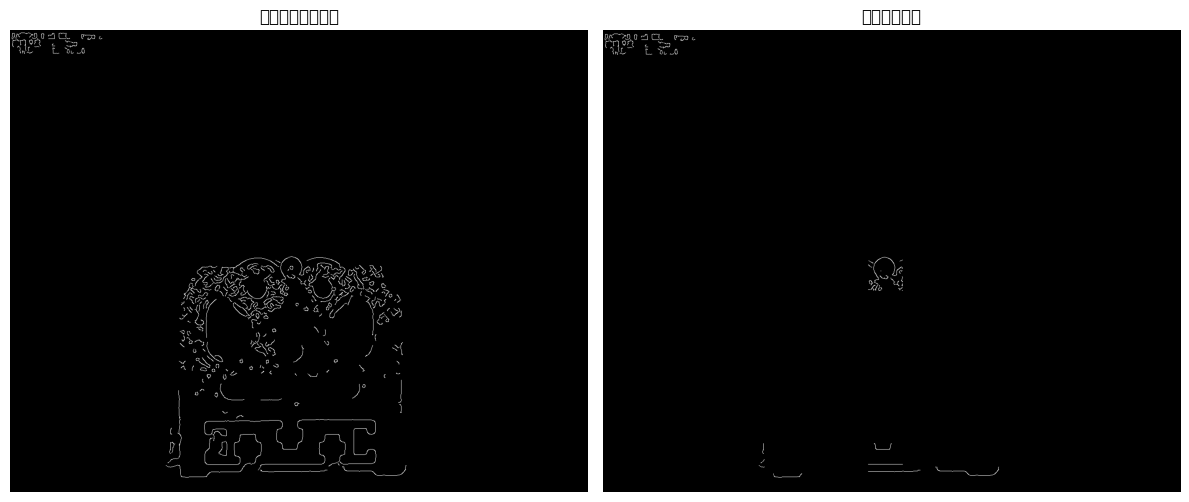

屏蔽区域:
  1: x=358, y=446, w=229, h=537
  2: x=664, y=435, w=267, h=533
  3: x=275, y=633, w=796, h=283
  4: x=575, y=578, w=210, h=138
  5: x=616, y=515, w=18, h=29


In [8]:
PHYSICAL_RADIUS_MM = 2.9  # 用于固定半径（毫米）
if scale_factor > 0:
    fixed_radius_px = float(PHYSICAL_RADIUS_MM / scale_factor)
else:
    fixed_radius_px = float(roi_radius)
print(f"固定半径: {PHYSICAL_RADIUS_MM} mm -> {fixed_radius_px:.2f} 像素")

mask_preview_gray = cv2.cvtColor(first_frame_for_interaction, cv2.COLOR_BGR2GRAY)
mask_preview_blurred = cv2.GaussianBlur(mask_preview_gray, (9, 9), 2)
mask_preview_edges = compute_canny(mask_preview_blurred)

ignored_rects = mask_edges_static(mask_preview_gray, mask_preview_edges)
masked_preview_edges = mask_preview_edges.copy()
apply_rect_masks(masked_preview_edges, ignored_rects)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("原始边缘（灰度）")
plt.imshow(mask_preview_edges, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("屏蔽后的边缘")
plt.imshow(masked_preview_edges, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

if ignored_rects:
    print("屏蔽区域:")
    for i, rect in enumerate(ignored_rects, 1):
        print(f"  {i}: x={rect[0]}, y={rect[1]}, w={rect[2]}, h={rect[3]}")
else:
    print("未屏蔽任何区域。")



帧 0: 方法=voting, 圆 = [624.       532.        23.436083], 票数=17


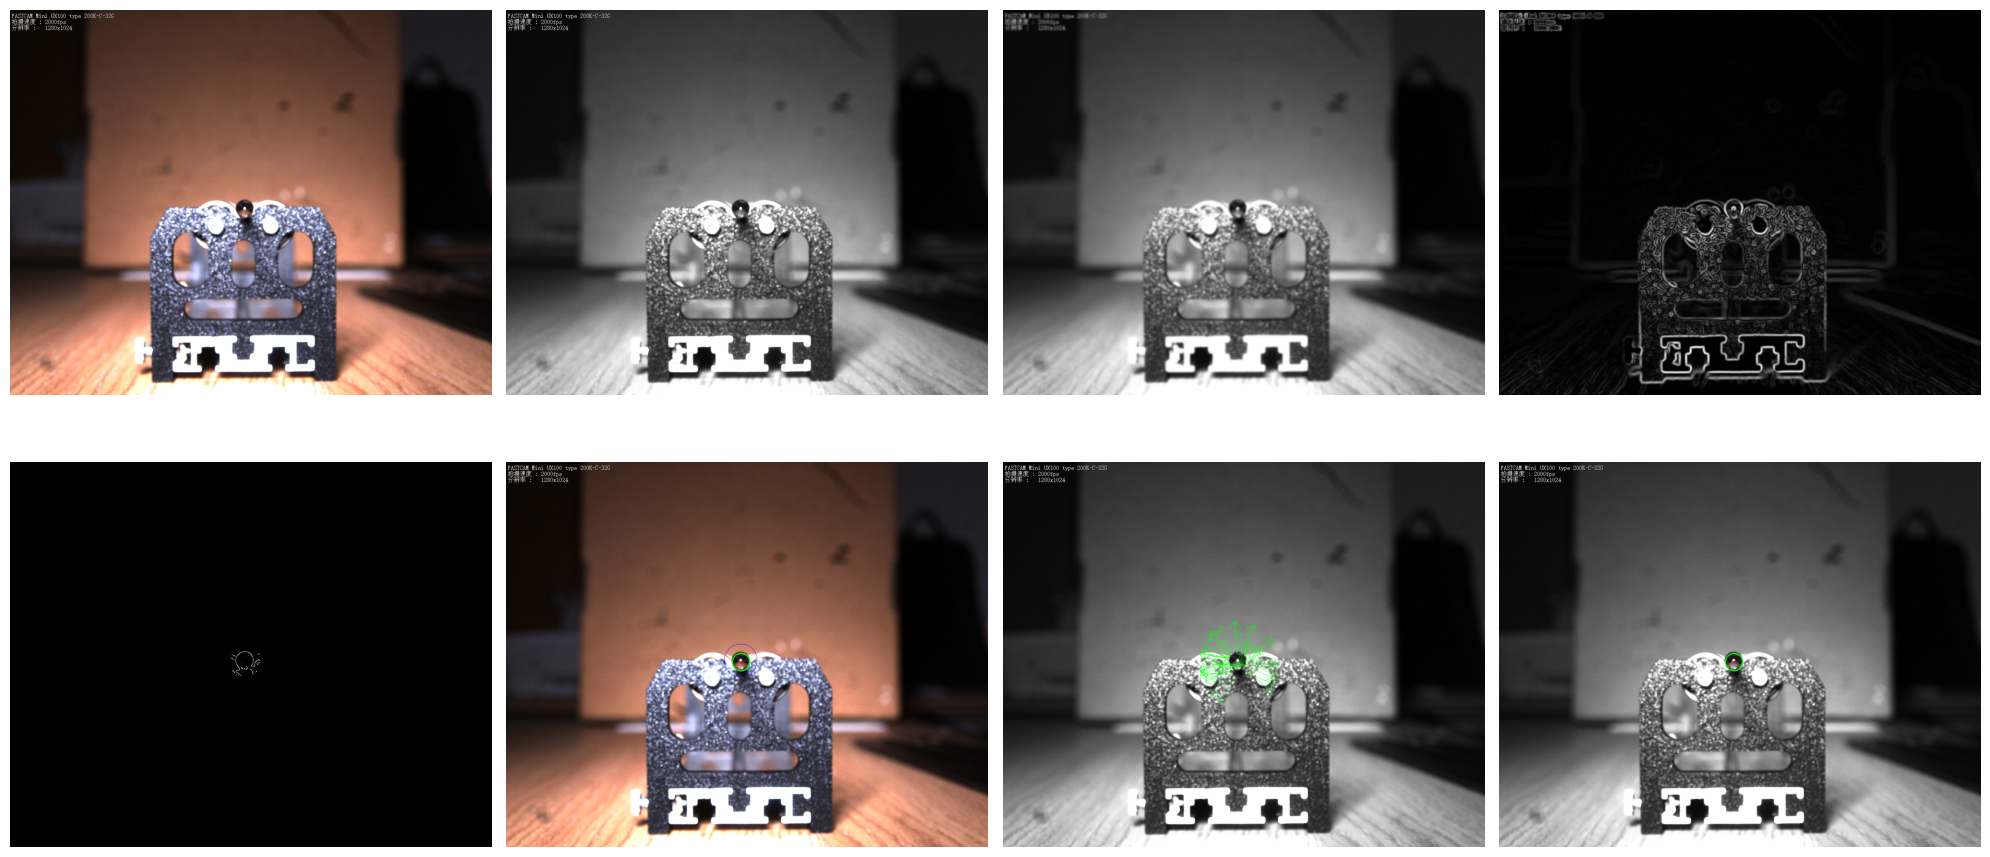

帧 10: 方法=voting, 圆 = [624.       533.        23.436083], 票数=16


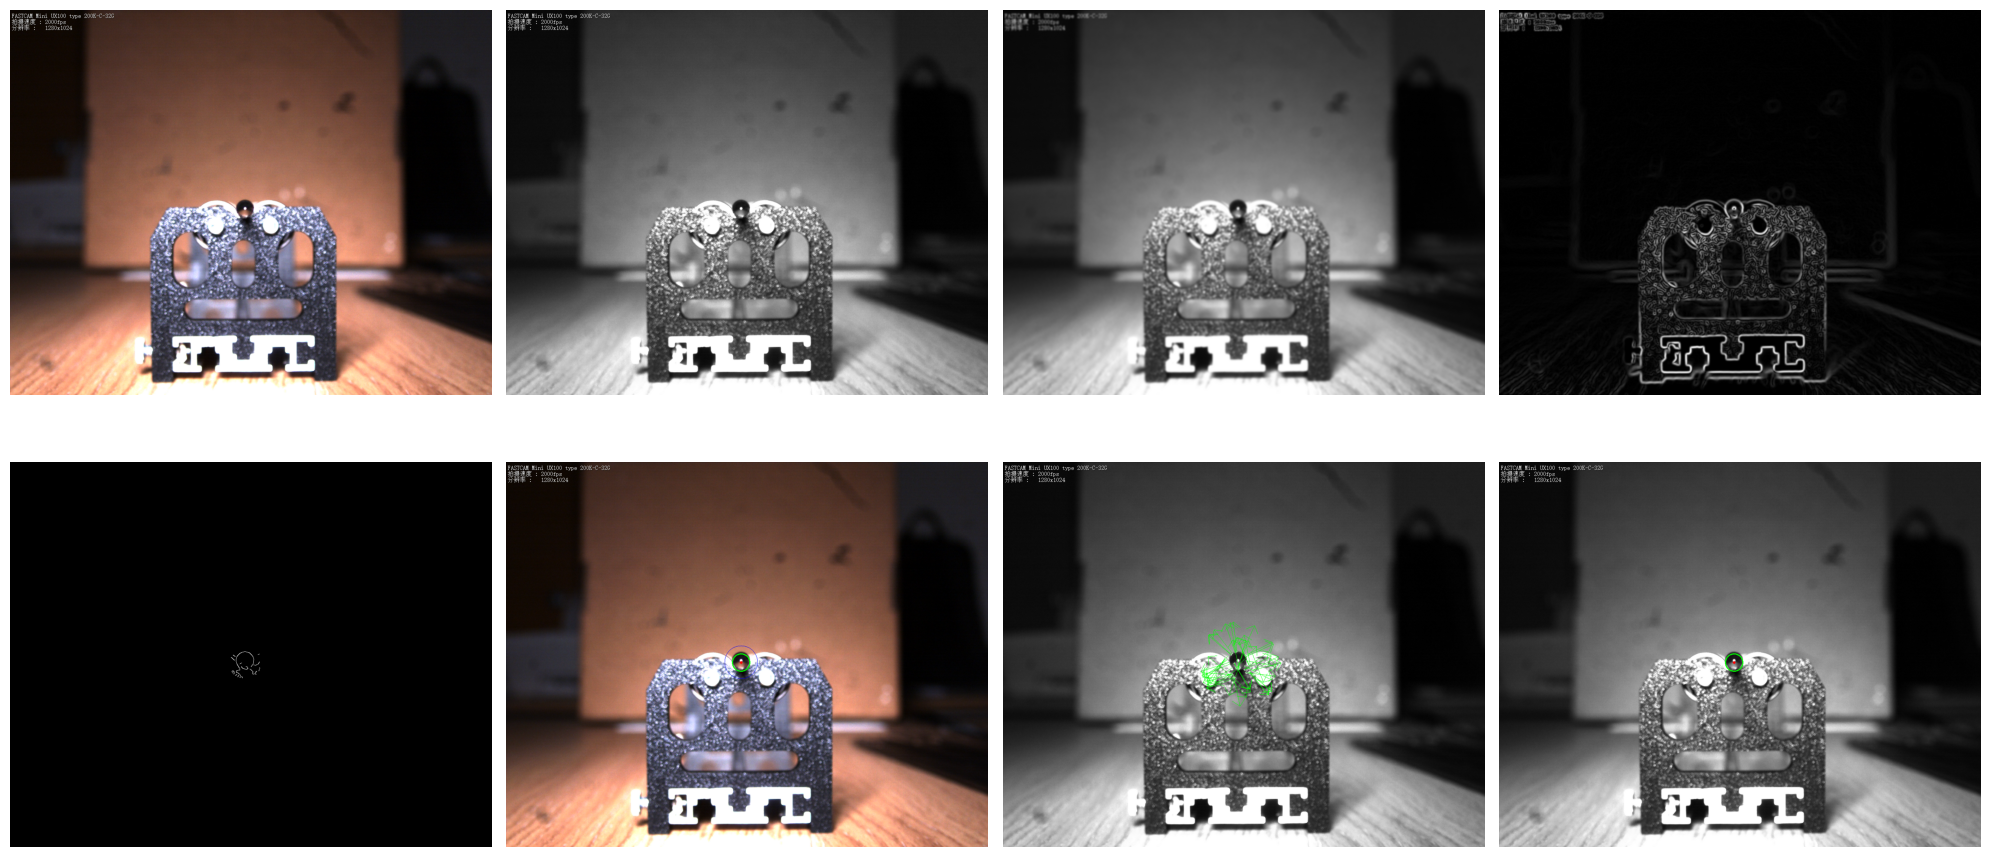

帧 25: 方法=voting, 圆 = [625.       533.        23.436083], 票数=24


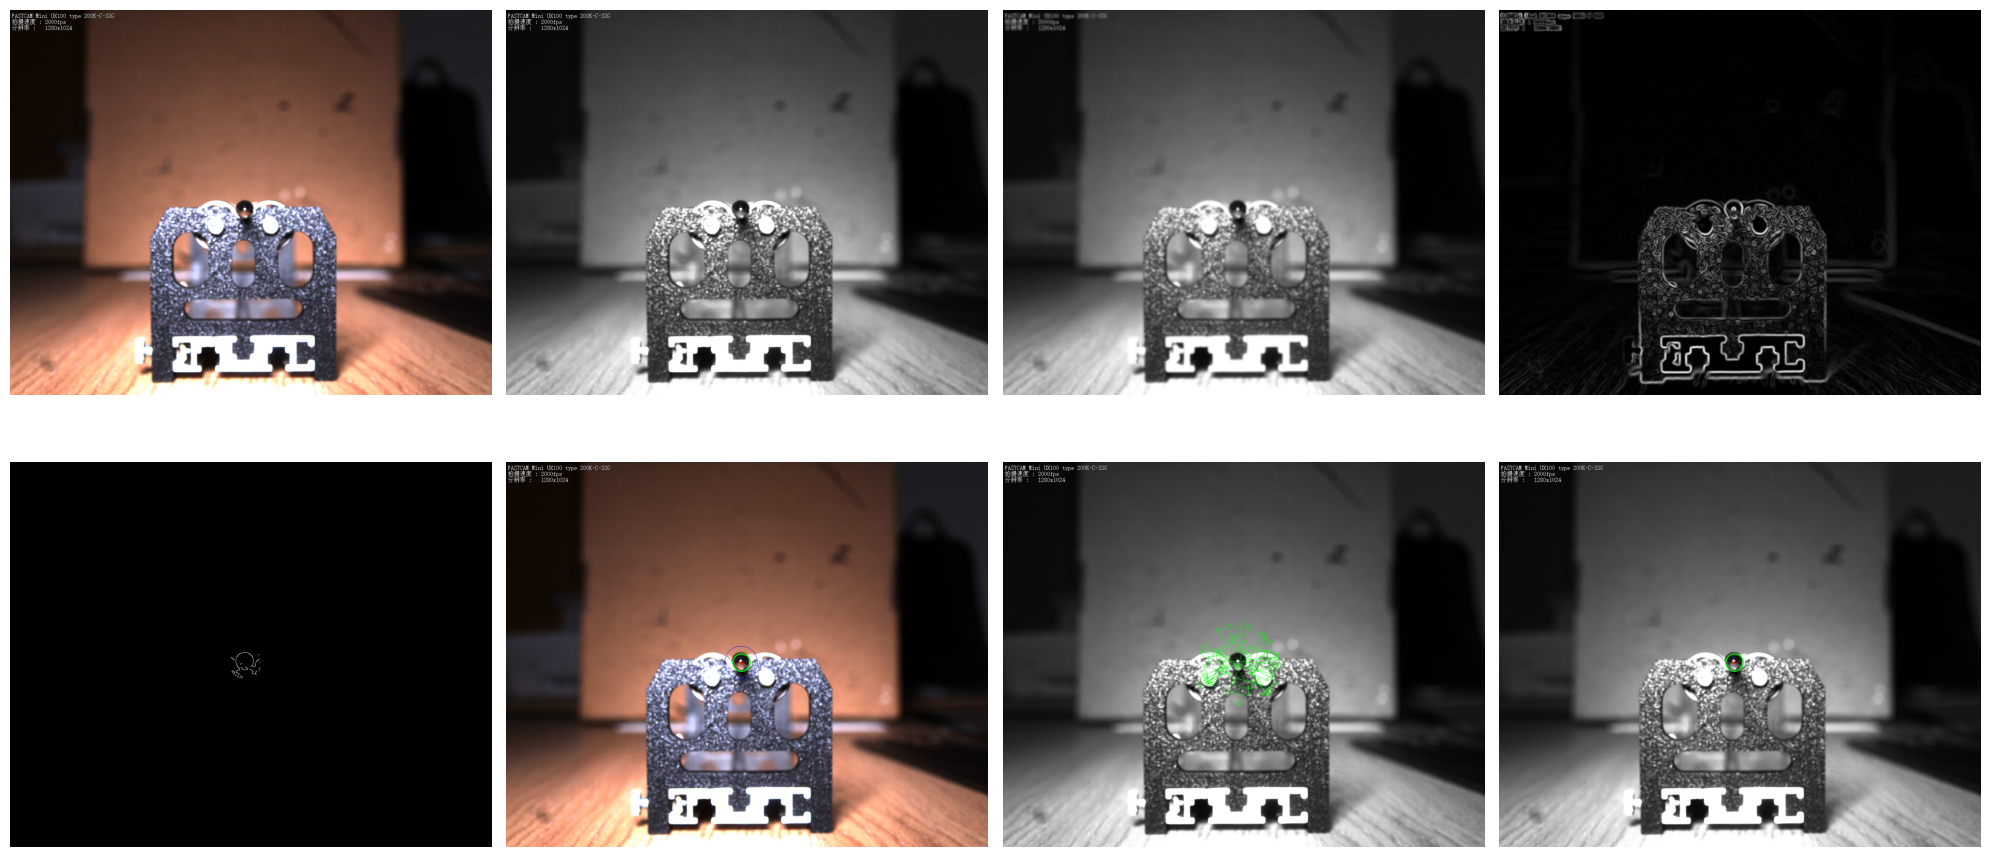

帧 50: 方法=voting, 圆 = [624.       532.        23.436083], 票数=17


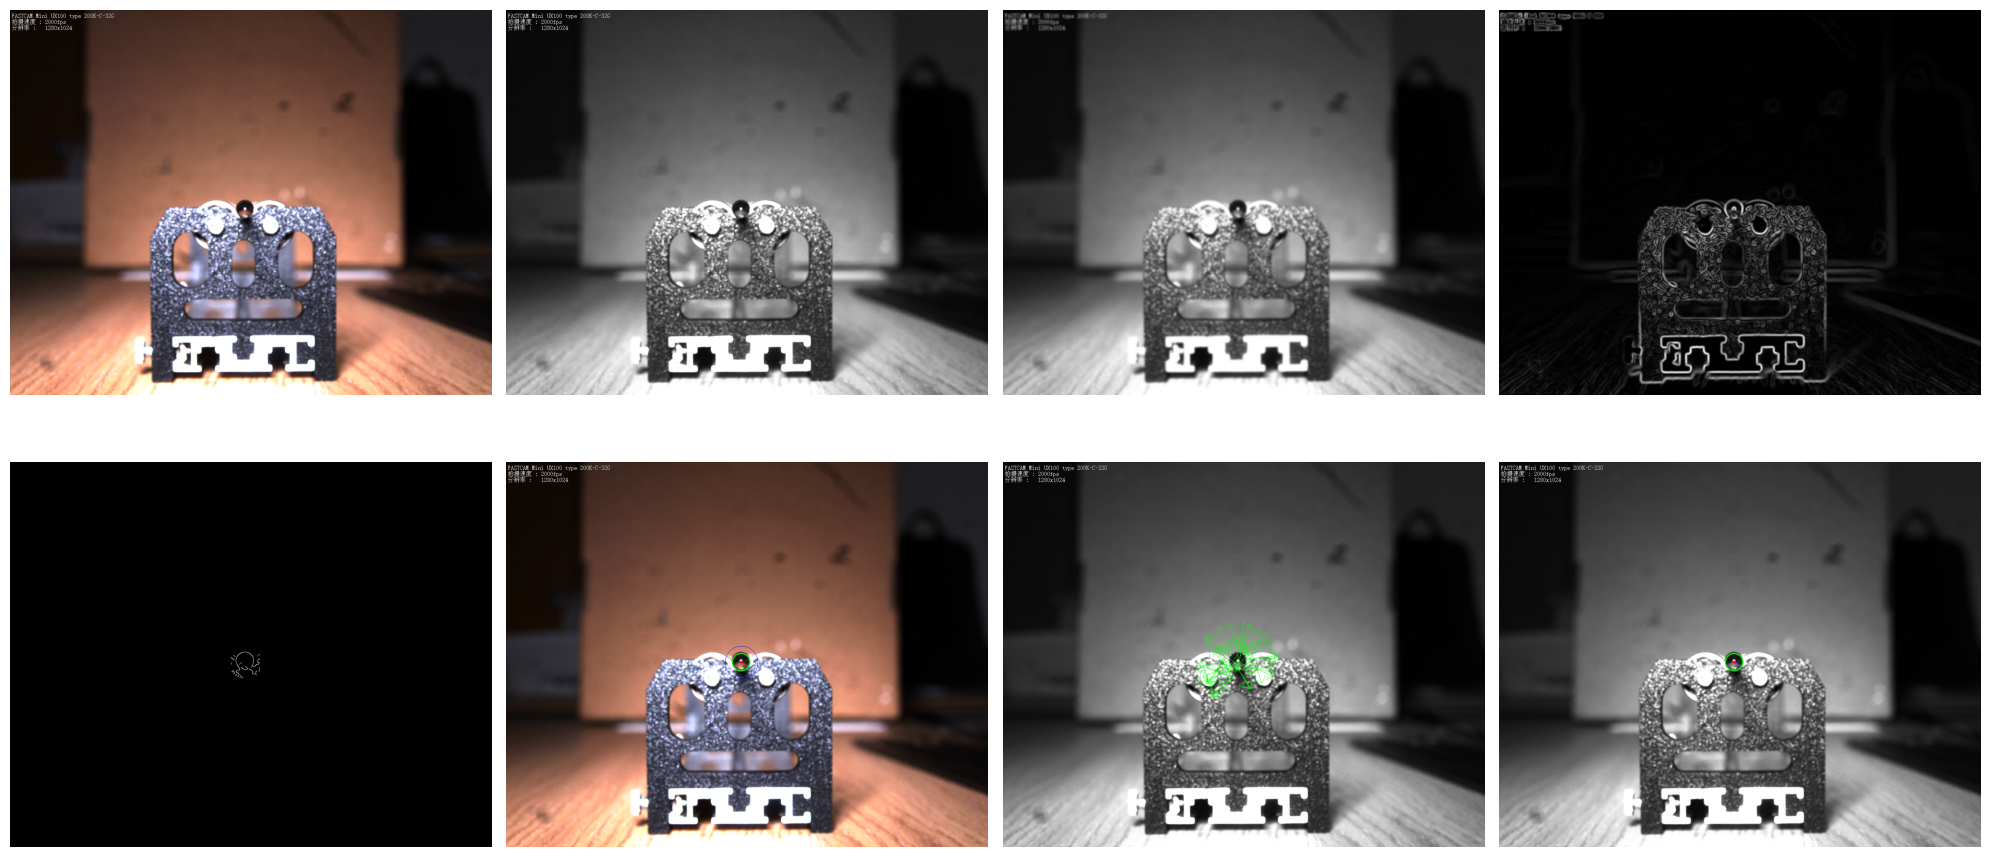

已完成自选帧逐步展示。
候选圆列表(x,y,r):
  0: 623,527, r=23


In [9]:
import matplotlib.pyplot as plt

if roi_center is None or roi_radius is None:
    raise RuntimeError("请先运行 ROI 选择单元，获取初始圆。")

if 'ignored_rects' not in globals():
    ignored_rects = []
if 'fixed_radius_px' not in globals() or fixed_radius_px is None:
    fixed_radius_px = float(roi_radius)

selected_frame_records = []
last_center_for_selected = roi_center

for idx in sorted(set(frames_to_check)):
    frame = load_frame(str(video_path), idx)
    prepared = prepare_frame_for_detection(frame, search_center=last_center_for_selected,
                                           base_radius=roi_radius, margin=search_margin)
    gx, gy, mag, ang = compute_sobel(prepared['blurred'])
    edges = compute_canny(prepared['blurred'])
    if ignored_rects:
        edges = edges.copy()
        apply_rect_masks(edges, ignored_rects)
    roi_edges = edges
    if prepared['mask'] is not None:
        roi_edges = cv2.bitwise_and(edges, edges, mask=prepared['mask'])

    roi_bounds = compute_roi_bounds(last_center_for_selected, prepared['search_radius'],
                                    edges.shape[1], edges.shape[0])

    #修改投票参数
    vote_result = solve_center_voting_fixed_radius(
        roi_edges,
        prepared['gray'],
        fixed_radius_px,
        roi_box=roi_bounds,
        vote_threshold=15,
    )

    roi_for_hough = prepared['roi_gray']
    if ignored_rects:
        roi_for_hough = roi_for_hough.copy()
        apply_rect_masks(roi_for_hough, ignored_rects)
    circle_hough, raw_circles = detect_best_circle(roi_for_hough, last_center_for_selected, roi_radius)

    if vote_result is not None:
        circle = np.array([
            vote_result['center'][0],
            vote_result['center'][1],
            vote_result['radius'],
        ], dtype=np.float32)
        detection_method = 'voting'
        votes = vote_result['votes']
        vote_map = vote_result['vote_map']
    else:
        circle = circle_hough
        detection_method = 'hough' if circle_hough is not None else 'none'
        votes = 0
        vote_map = None

    annotated = annotate_detection(frame, circle, search_center=last_center_for_selected,
                                   search_radius=prepared['search_radius'])

    if circle is not None:
        last_center_for_selected = (int(circle[0]), int(circle[1]))

    print(f"帧 {idx}: 方法={detection_method}, 圆 = {circle if circle is not None else '未检测到'}, 票数={votes}")

    gx_vis = cv2.normalize(np.abs(gx), None, 0, 255, cv2.NORM_MINMAX)
    mag_vis = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    ys, xs = np.where(roi_edges > 0)
    sample_step = 8 if len(xs) > 0 else 1
    grad_vis = cv2.cvtColor(prepared['gray'], cv2.COLOR_GRAY2BGR)
    for x, y in zip(xs[::sample_step], ys[::sample_step]):
        cv2.circle(grad_vis, (int(x), int(y)), 1, (255, 255, 255), -1)
        theta = ang[y, x]
        arrow_len = 80
        dx = int(round(arrow_len * np.cos(theta)))
        dy = int(round(arrow_len * np.sin(theta)))
        start_pt = (int(x), int(y))
        end_pt = (int(x + dx), int(y + dy))
        cv2.arrowedLine(grad_vis, start_pt, end_pt, (0, 255, 0), 1, tipLength=0.3)

    # 最后一张图：灰度底 + 绿色追踪圆
    vote_vis = cv2.cvtColor(prepared['gray'], cv2.COLOR_GRAY2BGR)
    if circle is not None:
        cx_v, cy_v, r_v = int(circle[0]), int(circle[1]), int(circle[2])
        cv2.circle(vote_vis, (cx_v, cy_v), r_v, (0, 255, 0), 2)  # 绿色圆
        cv2.circle(vote_vis, (cx_v, cy_v), 2, (0, 0, 255), 3)    # 红色圆心

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes[0,0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); axes[0,0].axis('off')
    axes[0,1].imshow(prepared['gray'], cmap='gray'); axes[0,1].axis('off')
    axes[0,2].imshow(prepared['blurred'], cmap='gray'); axes[0,2].axis('off')
    axes[0,3].imshow(mag_vis, cmap='gray'); axes[0,3].axis('off')
    axes[1,0].imshow(roi_edges, cmap='gray'); axes[1,0].axis('off')
    axes[1,1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)); axes[1,1].axis('off')
    axes[1,2].imshow(cv2.cvtColor(grad_vis, cv2.COLOR_BGR2RGB)); axes[1,2].axis('off')
    axes[1,3].imshow(cv2.cvtColor(vote_vis, cv2.COLOR_BGR2RGB)); axes[1,3].axis('off')
    plt.tight_layout(); plt.show()

    save_npz(f"frame{idx:05d}_step_gradients.npz", gx=gx, gy=gy, mag=mag, ang=ang)

    selected_frame_records.append({
        "frame": idx,
        "method": detection_method,
        "votes": votes,
        "circle": circle.tolist() if circle is not None else None,
        "raw_circles": raw_circles.tolist() if raw_circles is not None else None
    })

print("已完成自选帧逐步展示。")

#先不使用，参考值
"""hough_info = (f"Hough: dp=1.2, minDist=100, param1=100, param2=30, "
              f"minR={max(int(roi_radius-15),5)}, maxR={int(roi_radius+15)}")
print(hough_info)
"""

if raw_circles is not None:
    print("候选圆列表(x,y,r):")
    for i,(x,y,r) in enumerate(np.uint16(np.around(raw_circles[0]))):
        print(f"  {i}: {x},{y}, r={r}")
    debug_vis = frame.copy()
    for x,y,r in np.uint16(np.around(raw_circles[0])):
        cv2.circle(debug_vis, (x,y), r, (0,0,255), 1)
else:
    print("false no detect")


In [10]:
cap = cv2.VideoCapture(str(video_path))
if not cap.isOpened():
    raise RuntimeError(f"无法打开视频: {video_path}")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"视频信息 -> FPS: {fps}, 尺寸: {width}x{height}")

if slow_motion_factor > 1.0:
    output_fps = max(fps / slow_motion_factor, 1)
else:
    output_fps = fps

fourcc = cv2.VideoWriter_fourcc(*'avc1')
out_writer = cv2.VideoWriter(str(full_output_path), fourcc, output_fps, (width, height))
if not out_writer.isOpened():
    print("无法使用H.264,尝试mp4v...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(str(full_output_path), fourcc, output_fps, (width, height))
if not out_writer.isOpened():
    print("无法使用mp4v,回退XVID/AVI...")
    fallback_path = Path(str(full_output_path).rsplit('.', 1)[0] + '.avi')
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out_writer = cv2.VideoWriter(str(fallback_path), fourcc, output_fps, (width, height))
    full_output_path = fallback_path

if not out_writer.isOpened():
    cap.release()
    raise RuntimeError("仍然无法创建输出视频。")

print(f"输出视频: {full_output_path}")

detected_centers = []
last_center = roi_center
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    search_center = last_center if last_center is not None else roi_center
    prepared = prepare_frame_for_detection(frame, search_center=search_center,
                                           base_radius=roi_radius, margin=search_margin)
    circle, _ = detect_best_circle(prepared['roi_gray'], search_center, roi_radius)

    if circle is not None:
        center_point = (int(circle[0]), int(circle[1]))
        last_center = center_point
        radius = int(circle[2])
    else:
        center_point = last_center
        radius = roi_radius if roi_radius else 0

    if center_point is None:
        center_point = (width // 2, height // 2)

    detected_centers.append(center_point)

    annotated = annotate_detection(frame, circle if circle is not None else None,
                                   search_center=search_center,
                                   search_radius=prepared['search_radius'])
    out_writer.write(annotated)
    frame_idx += 1

cap.release()
out_writer.release()
print(f"处理帧数: {frame_idx}, 圆心记录: {len(detected_centers)}")

视频信息 -> FPS: 30.0, 尺寸: 1280x1024
输出视频: D:\2516_05_C001H001S0001\2516_05_C001H001S0001_nb_output.mp4
处理帧数: 301, 圆心记录: 301


### 滤波、频谱、统计与轨迹


带通滤波: 4-6 Hz, 阶数 4


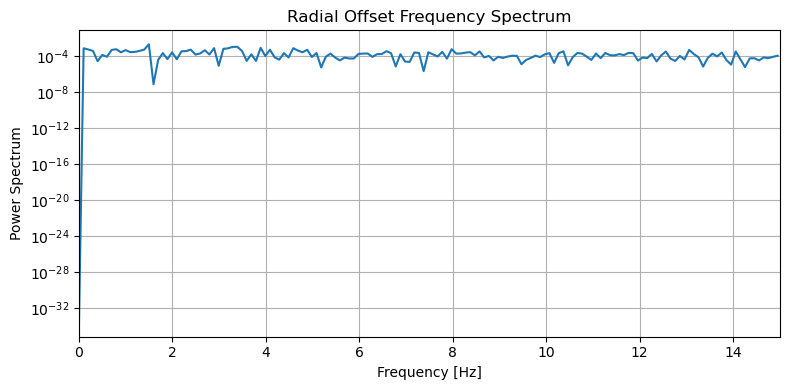

--- 统计结果 ---
稳定参考中心: (622.66, 527.85) 像素
最大径向偏移: 0.0908 mm
平均径向偏移: -0.0000 mm
径向偏移标准差: 0.0191 mm
最大两两距离（原始）: 1.0645 mm
最大两两距离（滤波）: 0.2310 mm
主频: 1.50 Hz, 幅值: 2.246e-03


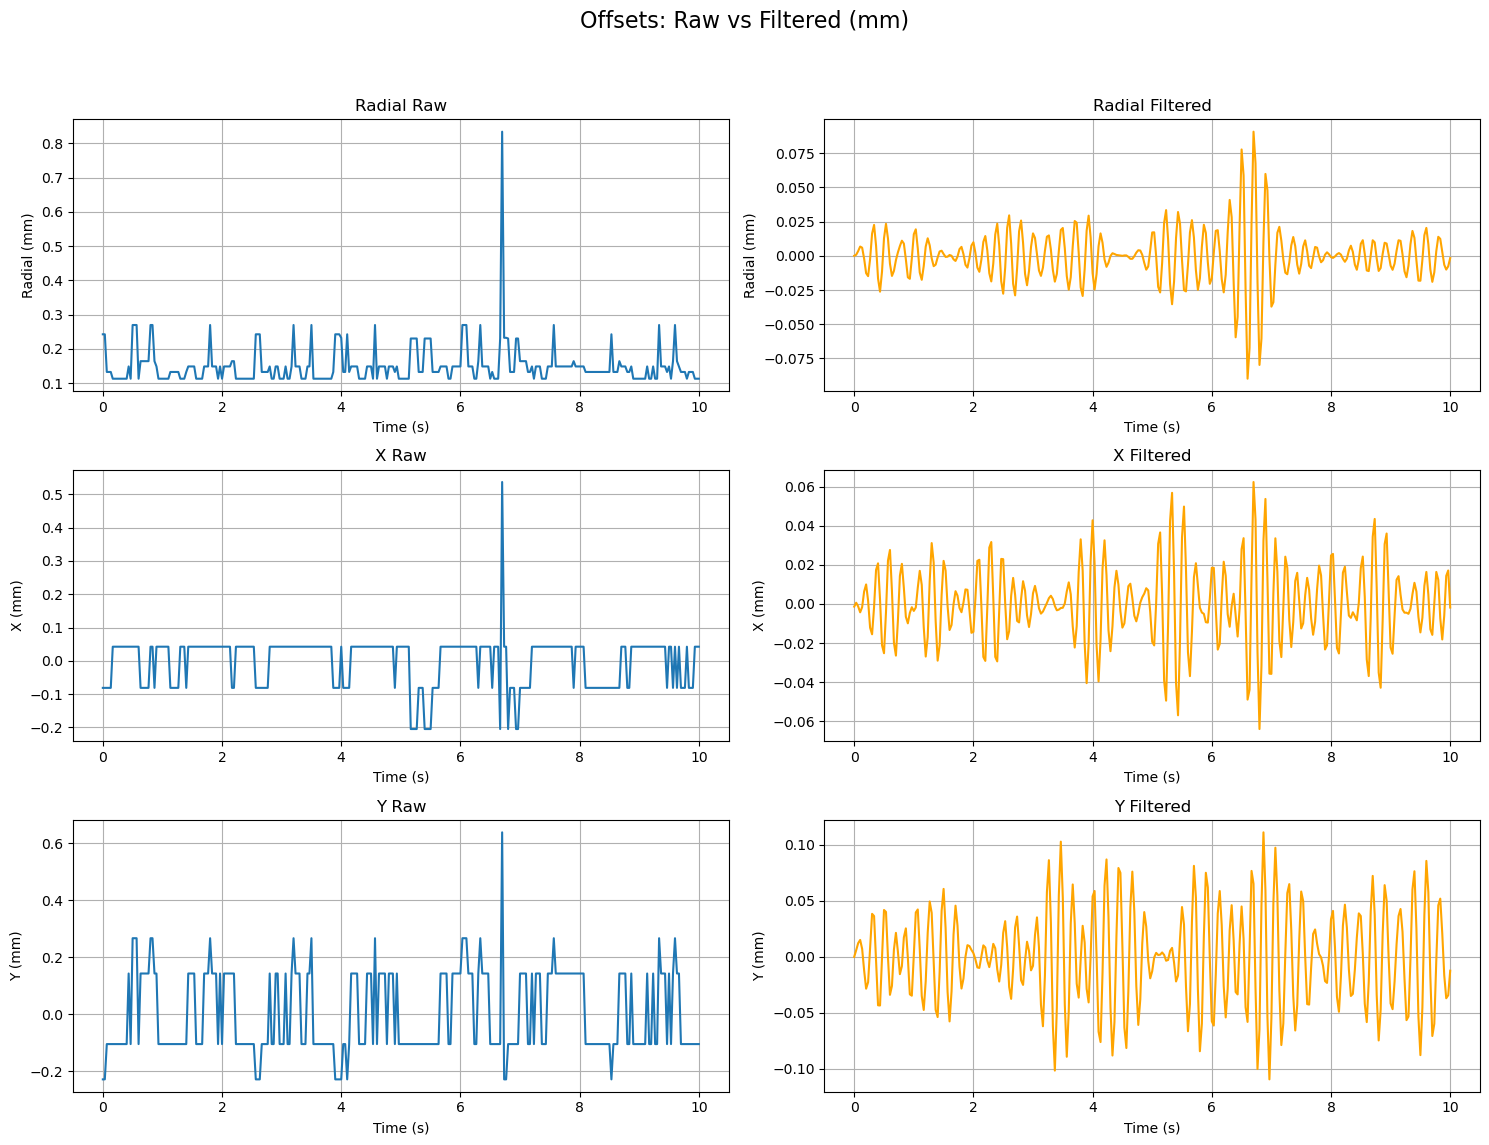

轨迹图保存: D:\2516_05_C001H001S0001\2516_05_C001H001S0001_trajectory_nb.png


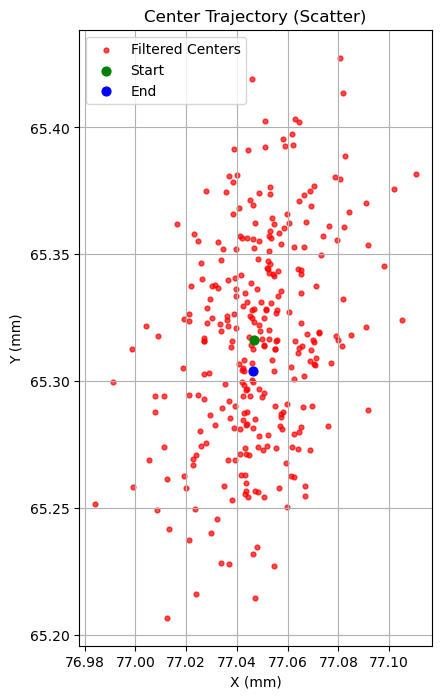

In [11]:
if not detected_centers:
    raise RuntimeError("没有检测到任何圆心，无法继续分析。")

detected_centers = np.array(detected_centers, dtype=np.float32)
stable_center = np.mean(detected_centers, axis=0)
offsets = detected_centers - stable_center
radial_offsets = np.linalg.norm(offsets, axis=1) * scale_factor

lowcut, highcut = freq_interval
print(f"带通滤波: {lowcut}-{highcut} Hz, 阶数 {filter_order}")

x_offsets = offsets[:, 0] * scale_factor
y_offsets = offsets[:, 1] * scale_factor

if len(x_offsets) > filter_order * 3:
    try:
        filtered_x = butter_bandpass_filter(x_offsets, lowcut, highcut, fps, order=filter_order)
        filtered_y = butter_bandpass_filter(y_offsets, lowcut, highcut, fps, order=filter_order)
        filtered_centers = np.column_stack([
            stable_center[0] + filtered_x / scale_factor,
            stable_center[1] + filtered_y / scale_factor
        ])
    except Exception as exc:
        print(f"滤波失败，使用原始数据: {exc}")
        filtered_x, filtered_y = x_offsets, y_offsets
        filtered_centers = detected_centers
else:
    print("数据长度不足以进行滤波，直接使用原始数据。")
    filtered_x, filtered_y = x_offsets, y_offsets
    filtered_centers = detected_centers

if len(radial_offsets) > filter_order * 3:
    try:
        filtered_radial = butter_bandpass_filter(radial_offsets, lowcut, highcut, fps, order=filter_order)
    except Exception as exc:
        print(f"径向滤波失败，直接使用原始数据: {exc}")
        filtered_radial = radial_offsets
else:
    filtered_radial = radial_offsets

pairwise_distances = []
for i in range(len(filtered_centers)):
    for j in range(i + 1, len(filtered_centers)):
        pairwise_distances.append(np.linalg.norm(filtered_centers[i] - filtered_centers[j]) * scale_factor)
max_pairwise_distance = max(pairwise_distances) if pairwise_distances else 0

raw_pairwise_distances = []
for i in range(len(detected_centers)):
    for j in range(i + 1, len(detected_centers)):
        raw_pairwise_distances.append(np.linalg.norm(detected_centers[i] - detected_centers[j]) * scale_factor)
max_raw_pairwise_distance = max(raw_pairwise_distances) if raw_pairwise_distances else 0

dom_freq, dom_amp = frequency_analysis(radial_offsets, fps,
    plot_title="Radial Offset Frequency Spectrum", show_plot=True)

mean_dev = np.mean(filtered_radial)
std_dev = np.std(filtered_radial)
max_dev = np.max(filtered_radial)

print("--- 统计结果 ---")
print(f"稳定参考中心: ({stable_center[0]:.2f}, {stable_center[1]:.2f}) 像素")
print(f"最大径向偏移: {max_dev:.4f} {units}")
print(f"平均径向偏移: {mean_dev:.4f} {units}")
print(f"径向偏移标准差: {std_dev:.4f} {units}")
print(f"最大两两距离（原始）: {max_raw_pairwise_distance:.4f} {units}")
print(f"最大两两距离（滤波）: {max_pairwise_distance:.4f} {units}")
if dom_freq is not None:
    print(f"主频: {dom_freq:.2f} Hz, 幅值: {dom_amp:.3e}")
else:
    print("未检测到有效主频")

time_axis = np.arange(len(radial_offsets)) / fps

plt.figure(figsize=(15, 12))
plt.suptitle(f"Offsets: Raw vs Filtered ({units})", fontsize=16)
plt.subplot(3, 2, 1); plt.plot(time_axis, radial_offsets); plt.title('Radial Raw'); plt.xlabel('Time (s)'); plt.ylabel(f'Radial ({units})'); plt.grid(True)
plt.subplot(3, 2, 2); plt.plot(time_axis, filtered_radial, color='orange'); plt.title('Radial Filtered'); plt.xlabel('Time (s)'); plt.ylabel(f'Radial ({units})'); plt.grid(True)
plt.subplot(3, 2, 3); plt.plot(time_axis, x_offsets); plt.title('X Raw'); plt.xlabel('Time (s)'); plt.ylabel(f'X ({units})'); plt.grid(True)
plt.subplot(3, 2, 4); plt.plot(time_axis, filtered_x, color='orange'); plt.title('X Filtered'); plt.xlabel('Time (s)'); plt.ylabel(f'X ({units})'); plt.grid(True)
plt.subplot(3, 2, 5); plt.plot(time_axis, y_offsets); plt.title('Y Raw'); plt.xlabel('Time (s)'); plt.ylabel(f'Y ({units})'); plt.grid(True)
plt.subplot(3, 2, 6); plt.plot(time_axis, filtered_y, color='orange'); plt.title('Y Filtered'); plt.xlabel('Time (s)'); plt.ylabel(f'Y ({units})'); plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(filtered_centers[:,0] * scale_factor, filtered_centers[:,1] * scale_factor, c='r', s=12, alpha=0.7, label='Filtered Centers')
ax.scatter(filtered_centers[0,0] * scale_factor, filtered_centers[0,1] * scale_factor, c='g', s=40, label='Start')
ax.scatter(filtered_centers[-1,0] * scale_factor, filtered_centers[-1,1] * scale_factor, c='b', s=40, label='End')
ax.set_xlabel(f'X ({units})'); ax.set_ylabel(f'Y ({units})'); ax.set_title('Center Trajectory (Scatter)'); ax.grid(True); ax.legend(); ax.set_aspect('equal', adjustable='box')
trajectory_path = Path(str(video_path).rsplit('.', 1)[0] + '_trajectory_nb.png')
plt.savefig(trajectory_path, dpi=300, bbox_inches='tight')
print(f"轨迹图保存: {trajectory_path}")
plt.show()